# Breast Cancer Detection

## import libaries

In [2]:
from tensorflow import lite
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import random, os
import cv2
import shutil
import keras
import matplotlib.pyplot as plt
from matplotlib.image import imread
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_accuracy
from sklearn.model_selection import train_test_split
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from imutils import paths
import cv2
import os
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelBinarizer
from imutils import paths
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from skimage.transform import resize
from skimage import io, color
from skimage.feature import canny
from skimage.filters import sobel
from skimage.transform import hough_line, hough_line_peaks
from skimage.draw import polygon

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Single image pre processing

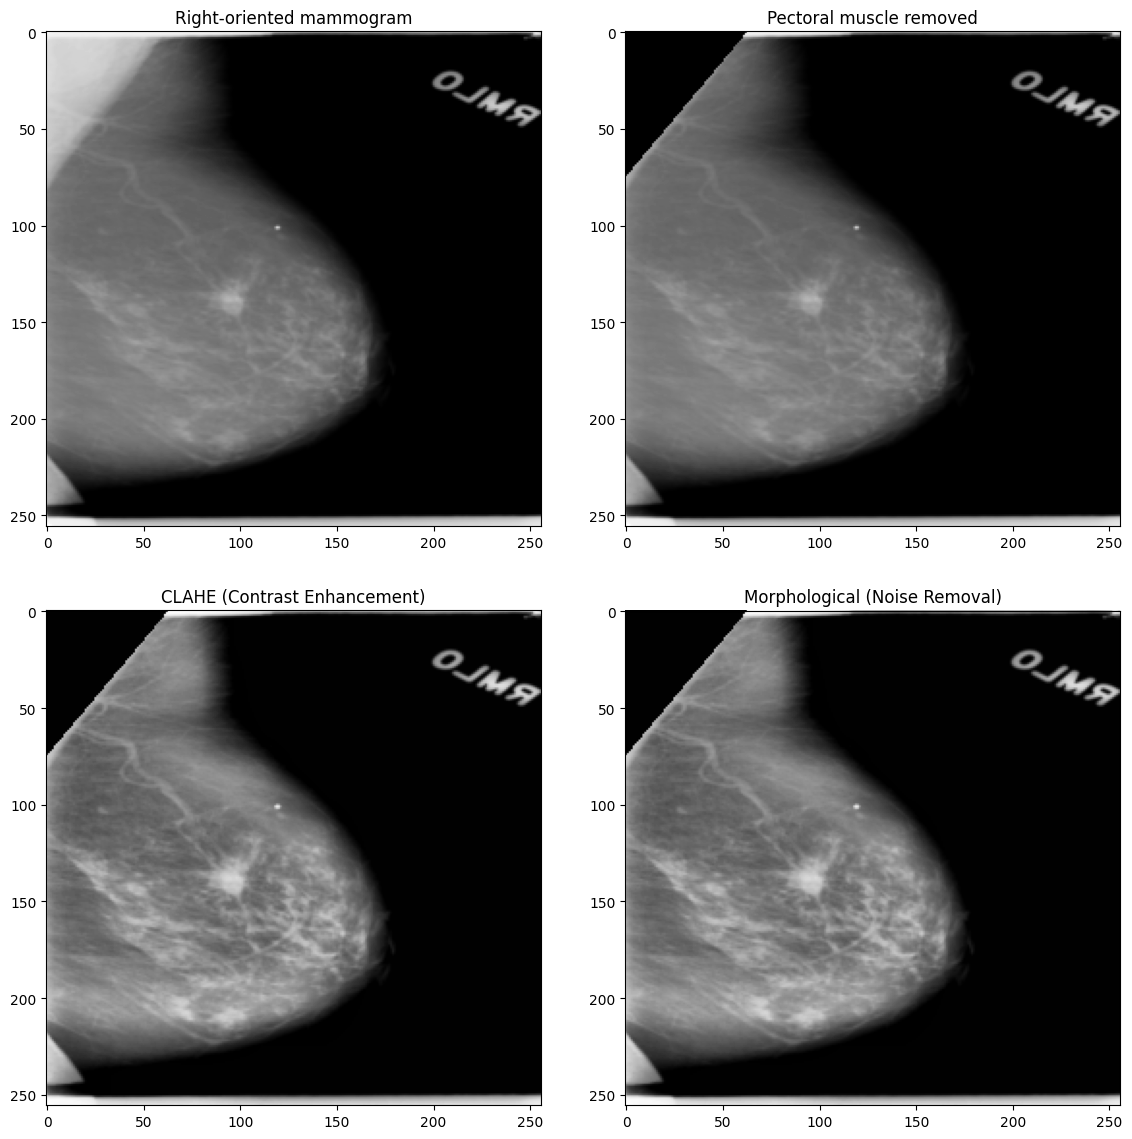

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage import io, color
import cv2
from skimage.feature import canny
from skimage.filters import sobel
from skimage.transform import hough_line, hough_line_peaks
from skimage.draw import polygon

def right_orient_mammogram(image):
    left_nonzero = cv2.countNonZero(image[:, 0:int(image.shape[1]/2)])
    right_nonzero = cv2.countNonZero(image[:, int(image.shape[1]/2):])

    if left_nonzero < right_nonzero:
        image = cv2.flip(image, 1)

    return image

def read_image(filename):
    image = io.imread(filename)
    image = resize(image, (256, 256, 3))
    image = color.rgb2gray(image)
    image = right_orient_mammogram(image)
    return image

def apply_canny(image):
    canny_img = canny(image, 6)
    return sobel(canny_img)

def get_hough_lines(canny_img):
    h, theta, d = hough_line(canny_img)
    lines = []

    for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
        x1 = 0
        y1 = (dist - x1 * np.cos(angle)) / np.sin(angle)
        x2 = canny_img.shape[1]
        y2 = (dist - x2 * np.cos(angle)) / np.sin(angle)
        lines.append({
            'dist': dist,
            'angle': np.degrees(angle),
            'point1': [x1, y1],
            'point2': [x2, y2]
        })

    return lines

def shortlist_lines(lines):
    MIN_ANGLE = 10
    MAX_ANGLE = 70
    MIN_DIST  = 5
    MAX_DIST  = 200

    shortlisted_lines = [x for x in lines if
                          (x['dist']>=MIN_DIST) &
                          (x['dist']<=MAX_DIST) &
                          (x['angle']>=MIN_ANGLE) &
                          (x['angle']<=MAX_ANGLE)
                        ]

    return shortlisted_lines

def remove_pectoral(shortlisted_lines):
    shortlisted_lines.sort(key = lambda x: x['dist'])
    pectoral_line = shortlisted_lines[0]
    d = pectoral_line['dist']
    theta = np.radians(pectoral_line['angle'])

    x_intercept = d/np.cos(theta)
    y_intercept = d/np.sin(theta)

    return polygon([0, 0, y_intercept], [0, x_intercept, 0])

# def preprocess_image(image): # Noise removal

#     if len(image.shape) > 2 and image.shape[2] > 1:
#         gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
#     else:
#         gray = image

#     # Thresholding to segment pectoral muscles
#     _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

#     # Apply morphological operations to enhance segmentation
#     kernel = np.ones((5, 5), np.uint8)
#     morphed = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=3)

#     # Find contours of segmented pectoral muscles
#     contours, _ = cv2.findContours(morphed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

#     # Draw contours on original image to highlight pectoral muscles
#     highlighted_image = cv2.drawContours(image.copy(), contours, -1, (0, 255, 0), thickness=cv2.FILLED)

#     return highlighted_image

def preprocess_image(image):
    # Convert image to grayscale if it's not already
    if len(image.shape) > 2 and image.shape[2] > 1:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray = image

    # Thresholding to segment pectoral muscles
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Apply morphological operations to enhance segmentation
    kernel = np.ones((5, 5), np.uint8)
    morphed = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=3)

    # Find contours of segmented pectoral muscles
    contours, _ = cv2.findContours(morphed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Convert image to RGB (if it's not already) to draw contours in color
    if len(image.shape) == 2:
        image_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    else:
        image_rgb = image

    # Draw contours on original image to highlight pectoral muscles (in green color)
    highlighted_image = cv2.drawContours(image_rgb, contours, -1, (0, 133, 0), thickness=cv2.FILLED)

    return highlighted_image


#def segment(image):
    #if image is None:
        #return None

    # Convert the image to grayscale if it has multiple channels
    #if len(image.shape) > 2 and image.shape[2] > 1:
        #gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    #else:
        #gray = image

    # Apply Gaussian Blur for noise reduction
    #blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Perform edge detection using Canny
    #edges = cv2.Canny(blurred, 3, 5)

    # Find contours in the edge-detected image
    #contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create a mask to store the segmented region
    #mask = np.zeros_like(gray)

    # Draw contours on the mask
    #cv2.drawContours(mask, contours, -1, (255, 255, 255), thickness=cv2.FILLED)

    # Apply the mask to the original image
    #segmented_img = cv2.bitwise_and(image, image, mask=mask)

    #return segmented_img


def display_image(filename):
    image = read_image(filename)
    canny_image = apply_canny(image)
    lines = get_hough_lines(canny_image)
    shortlisted_lines = shortlist_lines(lines)

    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    fig.tight_layout(pad=3.0)

    axes[0, 0].set_title('Right-oriented mammogram')
    axes[0, 0].imshow(image, cmap='gray')
    axes[0, 0].axis('on')

    try:
        rr, cc = remove_pectoral(shortlisted_lines)
        image[rr, cc] = 0
        axes[0, 1].set_title('Pectoral muscle removed')
        axes[0, 1].imshow(image, cmap='gray')
        axes[0, 1].axis('on')

        # Convert image to 8-bit unsigned integer format
        image_uint8 = (image * 255).astype(np.uint8)

        # Apply CLAHE on the image with pectoral muscle removed
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        clahe_image = clahe.apply(image_uint8)

        axes[1, 0].set_title('CLAHE (Contrast Enhancement)')
        axes[1, 0].imshow(clahe_image, cmap='gray')
        axes[1, 0].axis('on')

        morphological_img = preprocess_image(clahe_image)

        axes[1, 1].set_title('Morphological (Noise Removal)')
        axes[1, 1].imshow(morphological_img, cmap='gray')
        axes[1, 1].axis('on')

        #segmented_img = segment(morphological_img)

        #axes[2, 0].set_title('Segmented')
        #axes[2, 0].imshow(segmented_img, cmap='gray')
        #axes[2, 0].axis('on')

    except IndexError:
        # Handle the case where no pectoral muscle lines are detected
        axes[0, 1].set_title('Pectoral muscle not detected')
        axes[0, 1].imshow(image, cmap='gray')
        axes[0, 1].axis('on')

         # Convert image to 8-bit unsigned integer format
        image_uint8 = (image * 255).astype(np.uint8)

        # Apply CLAHE directly on the grayscale image
        clahe = cv2.createCLAHE(clipLimit=0.1, tileGridSize=(4, 4))
        clahe_image = clahe.apply(image_uint8)

        axes[1, 0].set_title('CLAHE (Contrast Enhancement)')
        axes[1, 0].imshow(clahe_image, cmap='gray')
        axes[1, 0].axis('on')

        morphological_img = preprocess_image(clahe_image)

        axes[1, 1].set_title('Morphological (Noise Removal)')
        axes[1, 1].imshow(morphological_img, cmap='gray')
        axes[1, 1].axis('on')

        #segmented_img = segment(morphological_img)

        #axes[2, 0].set_title('Segmented')
        #axes[2, 0].imshow(segmented_img, cmap='gray')
        #axes[2, 0].axis('on')

        plt.show()

display_image('/content/drive/MyDrive/BreastCancer/sample/sample2.jpg')

## preprocessing

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage import io, color
import cv2
from skimage.feature import canny
from skimage.filters import sobel
from skimage.transform import hough_line, hough_line_peaks
from skimage.draw import polygon

def right_orient_mammogram(image):
    left_nonzero = cv2.countNonZero(image[:, 0:int(image.shape[1]/2)])
    right_nonzero = cv2.countNonZero(image[:, int(image.shape[1]/2):])

    if left_nonzero < right_nonzero:
        image = cv2.flip(image, 1)

    return image

def read_image(filename):
    image = io.imread(filename)
    image = resize(image, (256, 256, 3))
    image = color.rgb2gray(image)
    image = right_orient_mammogram(image)
    return image

def apply_canny(image):
    canny_img = canny(image, 6)
    return sobel(canny_img)

def get_hough_lines(canny_img):
    h, theta, d = hough_line(canny_img)
    lines = []

    for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
        x1 = 0
        y1 = (dist - x1 * np.cos(angle)) / np.sin(angle)
        x2 = canny_img.shape[1]
        y2 = (dist - x2 * np.cos(angle)) / np.sin(angle)
        lines.append({
            'dist': dist,
            'angle': np.degrees(angle),
            'point1': [x1, y1],
            'point2': [x2, y2]
        })

    return lines

def shortlist_lines(lines):
    MIN_ANGLE = 10
    MAX_ANGLE = 70
    MIN_DIST  = 5
    MAX_DIST  = 200

    shortlisted_lines = [x for x in lines if
                          (x['dist']>=MIN_DIST) &
                          (x['dist']<=MAX_DIST) &
                          (x['angle']>=MIN_ANGLE) &
                          (x['angle']<=MAX_ANGLE)
                        ]

    return shortlisted_lines

def remove_pectoral(shortlisted_lines):
    shortlisted_lines.sort(key = lambda x: x['dist'])
    pectoral_line = shortlisted_lines[0]
    d = pectoral_line['dist']
    theta = np.radians(pectoral_line['angle'])

    x_intercept = d/np.cos(theta)
    y_intercept = d/np.sin(theta)

    return polygon([0, 0, y_intercept], [0, x_intercept, 0])

def preprocess_image(image):
    # Convert image to grayscale if it's not already
    if len(image.shape) > 2 and image.shape[2] > 1:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray = image

    # Thresholding to segment pectoral muscles
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Apply morphological operations to enhance segmentation
    kernel = np.ones((5, 5), np.uint8)
    morphed = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=3)

    # Find contours of segmented pectoral muscles
    contours, _ = cv2.findContours(morphed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw contours on original image to highlight pectoral muscles
    highlighted_image = cv2.drawContours(image.copy(), contours, -1, (0, 0, 255), thickness=cv2.FILLED)

    return highlighted_image

def process_image(filename):
    canny_image = apply_canny(filename)
    lines = get_hough_lines(canny_image)
    shortlisted_lines = shortlist_lines(lines)

    try:
        rr, cc = remove_pectoral(shortlisted_lines)
        filename[rr, cc] = 0

        # Convert image to 8-bit unsigned integer format
        image_uint8 = (filename * 255).astype(np.uint8)

        # Apply CLAHE on the image with pectoral muscle removed
        clahe = cv2.createCLAHE(clipLimit=0.1, tileGridSize=(4, 4))
        clahe_image = clahe.apply(image_uint8)

        morphological_img = preprocess_image(clahe_image)

        return morphological_img

    except IndexError:
        # Handle the case where no pectoral muscle lines are detected
        # Convert image to 8-bit unsigned integer format
        image_uint8 = (filename * 255).astype(np.uint8)

        # Apply CLAHE directly on the grayscale image
        clahe = cv2.createCLAHE(clipLimit=0.1, tileGridSize=(4, 4))
        clahe_image = clahe.apply(image_uint8)

        morphological_img = preprocess_image(clahe_image)

        return morphological_img


# Define the paths to the benign and malignant image folders
benign_folder = "/content/drive/MyDrive/BreastCancer/Dataset/Benign"
malignant_folder = "/content/drive/MyDrive/BreastCancer/Dataset/Malignant"

# Function to process images and assign labels
def process_images():
    data = []
    labels = []

    # Process images in the benign folder
    for filename in os.listdir(benign_folder):
        if filename.endswith(".jpg"):
            filepath = os.path.join(benign_folder, filename)
            image = read_image(filepath)
            processed_image = process_image(image)
            data.append(processed_image)
            labels.append(0)  # Assign label 0 for benign

    # Process images in the malignant folder
    for filename in os.listdir(malignant_folder):
        if filename.endswith(".jpg"):
            filepath = os.path.join(malignant_folder, filename)
            image = read_image(filepath)
            processed_image = process_image(image)
            data.append(processed_image)
            labels.append(1)  # Assign label 1 for malignant

    return data, labels

# Call the function to process images and assign labels
data, labels = process_images()

<ipython-input-4-f239a46b269a>:37: RuntimeWarning: divide by zero encountered in scalar divide
  y1 = (dist - x1 * np.cos(angle)) / np.sin(angle)
<ipython-input-4-f239a46b269a>:39: RuntimeWarning: divide by zero encountered in scalar divide
  y2 = (dist - x2 * np.cos(angle)) / np.sin(angle)


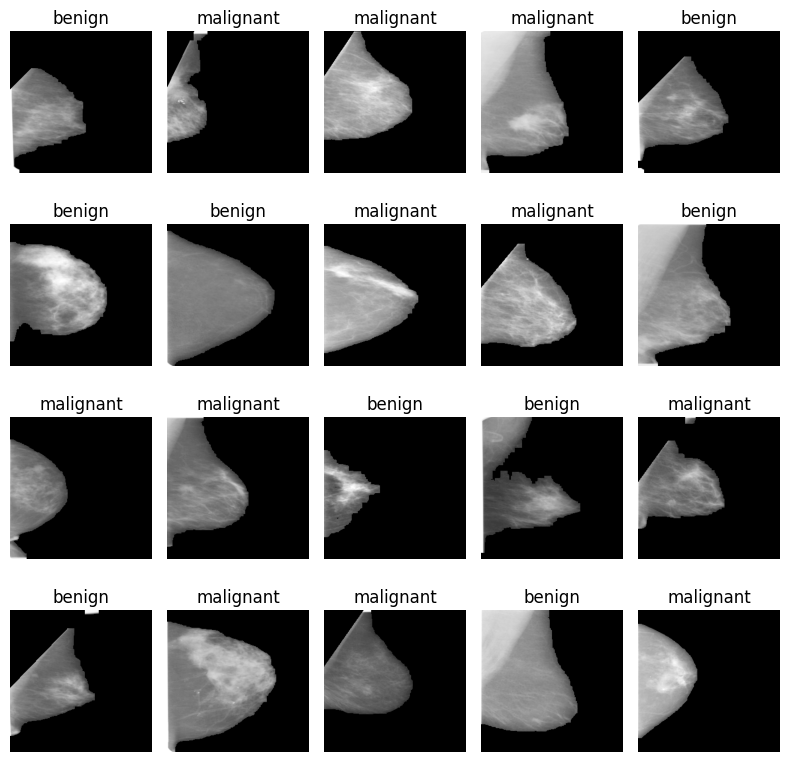

In [6]:
import random

labels_mapping = ['benign', 'malignant']

# Randomly select 16 indices
indices = random.sample(range(len(data)), 20)

# Create a 4x4 subplot grid
fig, axes = plt.subplots(4, 5, figsize=(8, 8))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Plot the randomly selected images along with their labels
for i, idx in enumerate(indices):
    axes[i].imshow(data[idx], cmap='gray')
    axes[i].set_title('{}'.format(labels_mapping[labels[idx]]))
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## save labels and data

In [ ]:
import numpy as np
import os

# Assuming you have data and labels as numpy arrays
data = np.array(data)
labels = np.array(labels)

# Create the directory if it does not exist
os.makedirs('models', exist_ok=True)

# Save data to a file
np.save('/content/drive/MyDrive/BreastCancer/models/processed_data.npy', data)

# Save labels to a text file
with open('models/labels.txt', 'w') as f:
    for label in labels:
        f.write(f"{label}\n")

In [ ]:
# import os
# import numpy as np
# import matplotlib.pyplot as plt

# # Create directories for benign and malignant images
# benign_dir = '/content/drive/MyDrive/BreastCancer/processed_images/benign'
# malignant_dir = '/content/drive/MyDrive/BreastCancer/processed_images/malignant'

# os.makedirs(benign_dir, exist_ok=True)
# os.makedirs(malignant_dir, exist_ok=True)

# # Assuming you have data and labels as numpy arrays
# for idx, (img, label) in enumerate(zip(data, labels)):
#     # Determine the directory based on the label
#     if label == 0:
#         directory = benign_dir
#     elif label == 1:
#         directory = malignant_dir
#     else:
#         continue

#     # Save the image in the respective directory
#     filename = f"image_{idx}.jpg"
#     filepath = os.path.join(directory, filename)
#     plt.imsave(filepath, img, cmap='gray')

# print("Images saved successfully.")

In [ ]:
def get_hough_lines(canny_img):
    h, theta, d = hough_line(canny_img)
    lines = []

    for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
        x1 = 0
        y1 = (dist - x1 * np.cos(angle)) / np.sin(angle)
        x2 = canny_img.shape[1]
        y2 = (dist - x2 * np.cos(angle)) / np.sin(angle)
        lines.append({
            'dist': dist,
            'angle': np.degrees(angle),
            'point1': [x1, y1],
            'point2': [x2, y2]
        })


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import hough_line, hough_line_peaks

def get_hough_lines(canny_img):
    h, theta, d = hough_line(canny_img)
    lines = []

    for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
        x1 = 0
        y1 = (dist - x1 * np.cos(angle)) / np.sin(angle)
        x2 = canny_img.shape[1]
        y2 = (dist - x2 * np.cos(angle)) / np.sin(angle)
        lines.append({
            'dist': dist,
            'angle': np.degrees(angle),
            'point1': [x1, y1],
            'point2': [x2, y2]
        })

    return lines

# Read the image and apply Canny edge detection
image = cv2.imread("pictue2.jpg", cv2.IMREAD_GRAYSCALE)
edges = cv2.Canny(image, 50, 150)

# Get detected lines using Hough Line Transform
detected_lines = get_hough_lines(edges)

# Plot the original image
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Original Image')

# Plot the detected lines
plt.subplot(122)
plt.imshow(edges, cmap='gray')
for line in detected_lines:
    plt.plot([line['point1'][0], line['point2'][0]],
             [line['point1'][1], line['point2'][1]], color='red')
plt.title('Detected Lines')

# Show the plot
plt.show()


AttributeError: 'NoneType' object has no attribute 'ndim'